In [17]:
%matplotlib inline

import pandas as pd
import numpy as np
import pickle
from bs4 import BeautifulSoup
import re

import nltk
from nltk.corpus import stopwords # Import the stop word list
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn import metrics
from sklearn import preprocessing
from sklearn.cross_validation import StratifiedKFold, train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt

In [2]:
lemmatizer=WordNetLemmatizer()

#Read pickle using pandas
train=pd.read_pickle("Fitbit_SMM_TweetsData.pkl")

# Remove the Neutral records
X=[]
y=[]
for record in train:
    if record['Label']=="Neutral":
       pass
    else:
        X.append(record['text'])
        y.append(0 if record['Label'] == "Negative" else 1)  # Convert Positive/Negative to 1/0
        
# Split the records into training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y,random_state=1)

# Oversampling of the negative data in the training set to overcome the problem of data imbalance
index=0
n_cnt=0
p_cnt=0
X_train_temp=[]
y_train_temp=[]
for i in range(0, len(X_train)-2):
    if y_train[i] == 0:
        # Oversampling
        X_train_temp.extend([X_train[i]]*10)
        y_train_temp.extend([0,0,0,0,0,0,0,0,0,0])
        n_cnt+=10        
    else:
        X_train_temp.append(X_train[i])
        y_train_temp.append(1)
        p_cnt+=1
        index+=1
        

X_train = X_train_temp
y_train = y_train_temp

print("Neutral count: " + str(len([i for i in train if i['Label'] == "Neutral"])))
print("Negative count: " + str(len([i for i in train if i['Label'] == "Negative"])))
print("Positive count: " + str(len([i for i in train if i['Label'] == "Positive"])))
print ("Positive-Negative " + str(p_cnt) + "-" + str(n_cnt))
print("Train-Test " + str(len(X_train)) + "-" + str(len(X_test)))

Neutral count: 64
Negative count: 78
Positive count: 1223
Positive-Negative 853-550
Train-Test 1403-391


In [3]:
def data_cleanup( raw_text ):
    # Function to convert a raw tweet to a string of words
    # The input is a single string (a tweet), and 
    # the output is a single string (a preprocessed tweet)
    #
    '''
    # 1. Remove HTML
    text = BeautifulSoup(raw_text, "lxml").get_text() 
    
    #
    # 2. Remove urls 
    words=text.split(' ')
    words=[w for w in words if not w.startswith('http') ]
    text=' '.join(words)
    
    #
    # 3. Remove non-letters        
    text = re.sub("[^0-9a-zA-Z]", " ", text) 
    text.replace("  ", " ")
    '''
    #
    # 4. Convert to lower case
    text=raw_text
    words = text.lower()  
    
    #
    # 5. Tokenize
    words=word_tokenize(words)
    
    #
    # 6. Lemmatize
    words = [lemmatizer.lemmatize(w) for w in words]
    
    #
    # 7. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))
    
    # 
    # 8. Remove stop words
    #words = [w for w in words if not w in stops]

    #
    # 9. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( words )) 

In [4]:
# Get the number of tweets based on the dataframe column size
num_tweets = len(X_train)

# Loop over each tweet; create an index i that goes from 0 to the length
# of the tweet list 
print ("Cleaning and parsing the training set ...\n")

# Initialize an empty list to hold the clean reviews
clean_train_tweets = []
for i in range( 0, num_tweets ):
    # Call our function for each one, and add the result to the list of
    # clean tweets
    clean_train_tweets.append(data_cleanup(X_train[i]))
    
print("Done")

Cleaning and parsing the training set ...

Done


In [5]:
# Get the number of tweets based on the dataframe column size
num_tweets_test = len(X_test)


# Loop over each tweet; create an index i that goes from 0 to the length
# of the tweet list 
print ("Cleaning and parsing the test set ...\n")

# Initialize an empty list to hold the clean reviews
clean_test_tweets = []
for i in range( 0, num_tweets_test ):
    # Call our function for each one, and add the result to the list of
    # clean tweets
    clean_test_tweets.append( data_cleanup( X_test[i] ))

print("Done")

Cleaning and parsing the test set ...

Done


In [6]:
print("creating the bag of words....\n")
from sklearn.feature_extraction.text import CountVectorizer

#initialize the CountVectorizer (scikit learn's bag-of-words tool)
#tried ngram_range=(1, 2),but performance went down for true negatives by a large margin
'''
#initialize the CountVectorizer (scikit learn's bag-of-words tool)
vectorizer = CountVectorizer(analyzer="word", tokenizer=None, preprocessor=None, 
                            stop_words=None, max_features=5000) '''
vectorizer = TfidfVectorizer(min_df=5,
                             max_df = 0.6,
                             sublinear_tf=False,
                             use_idf=True,max_features=5000)
#fit_transform will fit the model to learn the vocabulary with the data and then transform into feature vector...
train_data_features=vectorizer.fit_transform(clean_train_tweets)
#transform the test data...
test_data_features=vectorizer.transform(clean_test_tweets)

#convert to numpy arrays
train_data_features=train_data_features.toarray()
test_data_features=test_data_features.toarray()

print("Done")

creating the bag of words....

Done


<h3>LSA</h3>
There are many features in this data resulting in high dimensionality. LSA is used to compress the features into a small but informative set of features before using the data in a machine learning model. Since this is a sparse vector we do not normalize the data.

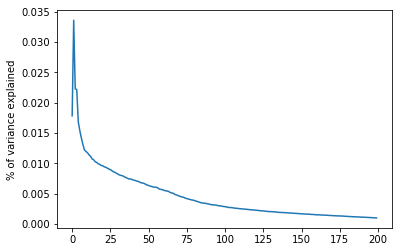

In [7]:
#LSA on the datasets..
from sklearn import decomposition
from sklearn import datasets

## LSA decomposition
lsa = decomposition.TruncatedSVD(n_components=200) #Finds first 200 
lsa.fit(train_data_features)
plt.plot(lsa.explained_variance_ratio_)
plt.ylabel('% of variance explained')
#plot reaches asymptote at around 85, which is optimal number of components to use. 


In [8]:

## LSA decomposition with optimal number of PCs
#decompose train data
lsa = decomposition.TruncatedSVD(n_components=85) 
lsa.fit(train_data_features)
train_data_features = lsa.transform(train_data_features)

#decompose test data
test_data_features = lsa.transform(test_data_features)

In [9]:
#A quick look at the features...
vocab=vectorizer.get_feature_names()
# print(vocab)

#Cross Validation
le = preprocessing.LabelEncoder()
Xtrain = train_data_features
Xtest = test_data_features
ytrain =le.fit_transform(y_train)
ytest = le.transform(y_test)
kfold = StratifiedKFold(y=ytrain,n_folds=5,random_state=1)

In [10]:
# Support Vector Machines
svm = SVC(kernel='linear',C=.3)
svm_scores = []
for k,(train,test) in enumerate(kfold): 
    svm.fit(Xtrain[train],ytrain[train]) 
    score = svm.score(Xtrain[test],ytrain[test]) 
    svm_scores.append(score)
svm.fit(Xtrain,ytrain)
# Using the Support Vector Machines to make sentiment label predictions
svm_result = svm.predict(test_data_features)

In [11]:
# Naive Bayes classifier
nbb = BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
nbb_scores = []
for k,(train,test) in enumerate(kfold): 
    nbb.fit(Xtrain[train],ytrain[train]) 
    score = nbb.score(Xtrain[test],ytrain[test]) 
    nbb_scores.append(score)
nbb.fit(Xtrain,ytrain)
# Using the Naive Bayes to make sentiment label predictions
nbb_result = nbb.predict(test_data_features)

In [12]:
#Logistic Regression With Cross Validation
lr = LogisticRegression(C=10) 
lr_scores = [] 
for k,(train,test) in enumerate(kfold): 
    lr.fit(Xtrain[train],ytrain[train]) 
    score = lr.score(Xtrain[test],ytrain[test]) 
    lr_scores.append(score)
lr.fit(Xtrain,ytrain)    
# Using the Logistic Regression classfication to make sentiment label predictions
lr_result = lr.predict(test_data_features)

In [13]:

print("************ Support Vector Machines ***********")
print("Support Vector Machines - Scores = " + str(svm_scores))
print("Accuracy = " + str(svm.score(test_data_features,ytest)))
svm_cm = metrics.confusion_matrix(ytest, svm_result)
print("Confusion Matrix = ")
print(svm_cm)
svm_tp = svm_cm[1][1]*100 / float(svm_cm[1][0] + svm_cm[1][1])
svm_tn = svm_cm[0][0]*100 / float(svm_cm[0][0] + svm_cm[0][1])
print("True Positive % match =  " + str(svm_tp))
print("True Negative % match =  " + str(svm_tn))
print("")

print("************ Naive Bayes B ***********")
print("Naive Bayes - Scores = " + str(nbb_scores))
print("Accuracy = " + str(nbb.score(test_data_features,ytest)))
nbb_cm = metrics.confusion_matrix(ytest, nbb_result)
print("Confusion Matrix = ")
print(nbb_cm)
nbb_tp = nbb_cm[1][1]*100 / float(nbb_cm[1][0] + nbb_cm[1][1])
nbb_tn = nbb_cm[0][0]*100 / float(nbb_cm[0][0] + nbb_cm[0][1])
print("True Positive % match =  " + str(nbb_tp))
print("True Negative % match =  " + str(nbb_tn))
print("")

print("************ Logistic Regression ***********")
print("Logistic Regression - Scores = " + str(lr_scores))
print("Accuracy = " + str(lr.score(test_data_features,ytest)))
lr_cm = metrics.confusion_matrix(ytest, lr_result)
print("Confusion Matrix = ")
print(lr_cm)
lr_tp = lr_cm[1][1]*100 / float(lr_cm[1][0] + lr_cm[1][1])
lr_tn = lr_cm[0][0]*100 / float(lr_cm[0][0] + lr_cm[0][1])
print("True Positive % match =  " + str(lr_tp))
print("True Negative % match =  " + str(lr_tn))
print("")

************ Support Vector Machines ***********
Support Vector Machines - Scores = [0.64768683274021355, 0.62989323843416367, 0.57295373665480431, 0.625, 0.58571428571428574]
Accuracy = 0.869565217391
Confusion Matrix = 
[[ 13  10]
 [ 41 327]]
True Positive % match =  88.8586956522
True Negative % match =  56.5217391304

************ Naive Bayes B ***********
Naive Bayes - Scores = [0.69039145907473309, 0.68683274021352314, 0.604982206405694, 0.61785714285714288, 0.69285714285714284]
Accuracy = 0.823529411765
Confusion Matrix = 
[[ 11  12]
 [ 57 311]]
True Positive % match =  84.5108695652
True Negative % match =  47.8260869565

************ Logistic Regression ***********
Logistic Regression - Scores = [0.62277580071174377, 0.64056939501779364, 0.58007117437722422, 0.59999999999999998, 0.59642857142857142]
Accuracy = 0.915601023018
Confusion Matrix = 
[[  8  15]
 [ 18 350]]
True Positive % match =  95.1086956522
True Negative % match =  34.7826086957



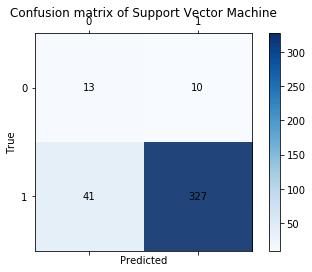

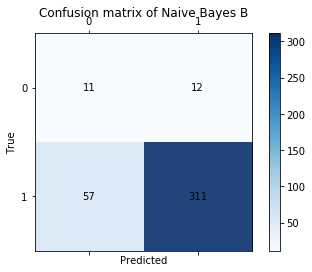

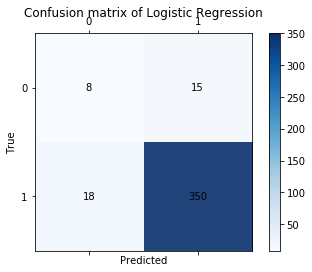

In [14]:
def plotConfusionMatrix(cm, algo):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm,cmap=plt.cm.Blues,alpha=.9)
    plt.title('Confusion matrix of ' + algo)
    fig.colorbar(cax)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j,y=i,
                   s=cm[i,j],
                   va='center',
                   ha='center')
    plt.xlabel('Predicted')
    plt.ylabel('True')    
    plt.show()
    
plotConfusionMatrix(svm_cm, "Support Vector Machine")
plotConfusionMatrix(nbb_cm, "Naive Bayes B")
plotConfusionMatrix(lr_cm, "Logistic Regression")

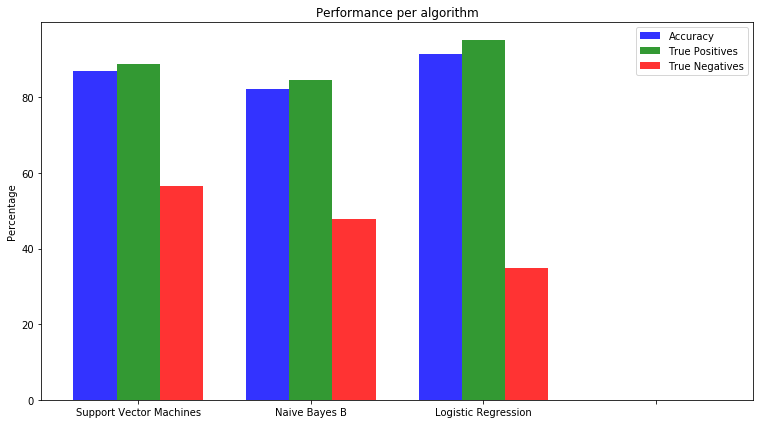

In [15]:
# data to plot
n_groups = 4
accuracy = [svm.score(test_data_features,ytest)*100.00,nbb.score(test_data_features,ytest)*100.00,lr.score(test_data_features,ytest)*100.00,0.0]
true_positive = (svm_tp,nbb_tp,lr_tp, 0.0)
true_negatives = (svm_tn,nbb_tn,lr_tn, 0.0)
 
# create plot
fig, ax = plt.subplots(figsize=(10.8,6))
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8
 
rects1 = plt.bar(index, accuracy, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Accuracy')
 
rects2 = plt.bar(index + bar_width, true_positive, bar_width,
                 alpha=opacity,
                 color='g',
                 label='True Positives')

rects3 = plt.bar(index + bar_width + bar_width, true_negatives, bar_width,
                 alpha=opacity,
                 color='r',
                 label='True Negatives')
 
plt.ylabel('Percentage')
plt.title('Performance per algorithm')
plt.xticks(index + bar_width, ( 'Support Vector Machines', 'Naive Bayes B','Logistic Regression', ''))
plt.legend()
 
plt.tight_layout()
plt.show()

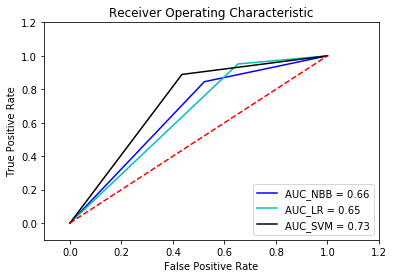

In [16]:
from sklearn.metrics import roc_curve, auc

fpr_nbb, tpr_nbb, thresholds_nbb = roc_curve(ytest, nbb_result)
roc_auc = auc(fpr_nbb, tpr_nbb)

fpr_lr, tpr_lr, thresholds_lr = roc_curve(ytest, lr_result)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_svm, tpr_svm, thresholds_svm = roc_curve(ytest, svm_result)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_nbb, tpr_nbb, 'b',label='AUC_NBB = %0.2f'% roc_auc)
plt.plot(fpr_lr, tpr_lr, 'c',label='AUC_LR = %0.2f'% roc_auc_lr)
plt.plot(fpr_svm, tpr_svm, 'k',label='AUC_SVM = %0.2f'% roc_auc_svm)

plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
